# Which Countries Love America the Most?
In this project, we extract US favorability from the quotations provided in the QuoteBank dataset.
The steps are as follows:
1. Load the dataset chunk by chunk and apply a keyword filter
2. Drop quotes with "None" speakers
3. Add the nationality of speakers to the dataframe
4. Extract the sentiment of the quotes using a sentiment analysis library
5. Show US favorability for every country
6. Load PEW Research Center Dataset and describe it
7. Compare the datasets of PEW and QuoteSentiment


## 1. Load QuoteBank
In this section, we show how to load the data and apply a filter to extract the quotes with special keywords.
However, this step is done on **Google Colab** because the process is faster.
The output files are saved in the colab and downloaded to have them locally.

The following code is run on Google Colab:



In [ ]:
import bz2
import json

keywords = ["US ", "U.S", "USA", "United States"]

for year in range(2015, 2021) :
  path_to_file = '/content/drive/MyDrive/us_data/Quotebank/quotes-'+year+'.json.bz2'
  path_to_out = '/content/drive/MyDrive/us_data/Filtered_data/quotes-'+year+'-us.json.bz2'
  with bz2.open(path_to_file, 'rb') as s_file:
      with bz2.open(path_to_out, 'wb') as d_file:
          for instance in s_file:
              instance = json.loads(instance) # loading a sample
              quote = instance['quotation'] # extracting list of links
              if any(word in quote for word in keywords) :
                d_file.write((json.dumps(instance)+'\n').encode('utf-8')) # writing in the new file

## 2. Load US-filtered data locally
In this part, we load the filtered data year by year and concatenate into a single dataframe.
However, since our goal is to categorize the quotations by their speaker's nationality, we need to ignore the quotes
whose speaker is "None".

In [1]:
import pandas as pd

# Get the index of None speaker quo
def drop_none_speaker(year, df):
    print("Year : {} with {} quotes".format(year, len(df)))
    drop_mask = df[df.speaker == "None"].index
    df_dropped = df.drop(drop_mask)
    print("{} quotes are removed".format(len(drop_mask)))
    return df_dropped

US_data = pd.DataFrame()
for year in range(2017, 2018) :
    year_df = pd.read_json('input/quotes-{}-us.json.bz2'.format(year), lines=True, compression='bz2')
    year_df = drop_none_speaker(year, year_df)
    US_data = pd.concat([US_data, year_df], axis=0)

US_data.sample(n=10)



Year : 2017 with 287824 quotes
111718 quotes are removed


,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase
227186,2017-04-07-051173,I think that the chances for an attack initiat...,Yaakov Amidror,[Q1517723],2017-04-07 07:48:42,2,"[[Yaakov Amidror, 0.7216], [None, 0.221], [Bar...",[http://news.yahoo.com/news/israel-backs-stron...,E
64908,2017-06-19-034146,I don't understand why there is no system in t...,Gerry Connolly,"[Q1514859, Q5552691]",2017-06-19 04:01:00,1,"[[Gerry Connolly, 0.6162], [None, 0.3838]]",[http://m.washingtonexaminer.com/lets-face-it-...,E
26561,2017-04-14-039412,I think her talk and the #ILookLikeASurgeon mo...,Susan Pitt,[Q7648290],2017-04-14 07:00:00,2,"[[Susan Pitt, 0.7435], [None, 0.2565]]",[https://www.washingtonpost.com/news/comic-rif...,E
206858,2017-11-10-126593,the United States has equal authority of Congr...,Rodrigo Duterte,[Q457786],2017-11-10 10:06:44,12,"[[Rodrigo Duterte, 0.5113], [None, 0.2775], [V...",[https://sg.news.yahoo.com/philippines-duterte...,E
129593,2017-05-02-003496,Absent a policy change allowing national patie...,Aneesh Chopra,[Q2849203],2017-05-02 13:00:00,2,"[[Aneesh Chopra, 0.6557], [None, 0.3443]]",[http://uspolitics.einnews.com/pr_news/3789413...,E
70024,2017-10-17-087375,Kissinger's authority to adequately convey the...,Ken Burns,"[Q1106967, Q616886]",2017-10-17 00:25:50,1,"[[Ken Burns, 0.7404], [None, 0.2161], [Henry K...",[http://p.washingtontimes.com/news/2017/oct/16...,E
45442,2017-10-23-113573,"The U.S. will need to work with others, includ...",Lee Hsien Loong,[Q57643],2017-10-23 00:00:00,25,"[[Lee Hsien Loong, 0.7427], [None, 0.1743], [P...",[http://euronews.com/2017/10/23/us-needs-to-wo...,E
192407,2017-10-17-125127,The future of US soccer is this runaway cow on...,Sopan Deb,[Q54054833],2017-10-17 17:04:01,1,"[[Sopan Deb, 0.802], [None, 0.198]]",[http://www.ibtimes.co.uk/theres-cow-loose-bro...,E
13858,2017-11-13-107536,The U.S. airlines have not established a case ...,Tim Clark,"[Q23418760, Q25190253, Q29642470, Q30315192, Q...",2017-11-13 12:38:00,2,"[[Tim Clark, 0.5195], [None, 0.4805]]",[http://aviationweek.com/commercial-aviation/c...,E
241165,2017-06-15-098340,should prioritize the export of United States ...,Isabelle Kocher,[Q24007702],2017-06-15 00:00:00,8,"[[Isabelle Kocher, 0.6838], [None, 0.3163]]",[http://www.rigzone.com/news/oil_gas/a/150609/...,E


## 3. Add nationality to the main df
In this part, we use the speaker attributes dataset provided on the project web page. We need only id and nationality of
 the speakers; therefore, we keep these two columns. Then, we map the speaker id in Quotebank to this library.

In [2]:
speaker_df = pd.read_parquet("input/speaker_attributes.parquet")
speaker_df = speaker_df[['id', 'nationality']]
speaker_df.head()


,id,nationality
0,Q23,"[Q161885, Q30]"
1,Q42,[Q145]
2,Q1868,[Q31]
3,Q207,[Q30]
4,Q297,[Q29]


In [3]:
US_data["speaker_id"] = US_data.qids.map(lambda x: x[0])

#join US_data with the corresponding speakers' attributes
US_merged = pd.merge(US_data, speaker_df, left_on=['speaker_id'], right_on=['id'], how='inner')
US_merged.sample(n=5)


,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase,speaker_id,id,nationality
116437,2017-09-01-106175,The global implications of a stormy season in ...,Ed Morse,[Q16732898],2017-09-01 06:58:09,1,"[[Ed Morse, 0.7596], [None, 0.2321], [Jeff Mar...",[http://www.arkansasonline.com/news/2017/sep/0...,E,Q16732898,Q16732898,[Q30]
70210,2017-06-08-021298,Director Comey's testimony is a reminder of th...,Louise Slaughter,[Q299833],2017-06-08 00:00:00,1,"[[Louise Slaughter, 0.8281], [None, 0.1448], [...",[http://www.whec.com/news/comey-testimony-sena...,E,Q299833,Q299833,[Q30]
2427,2017-08-12-039978,It's been going on for a long time in our coun...,President Trump,[Q22686],2017-08-12 19:57:55,6,"[[President Trump, 0.4815], [Ivanka Trump, 0.1...",[https://www.algemeiner.com/2017/08/13/trump-d...,E,Q22686,Q22686,[Q30]
18188,2017-10-20-068929,it is neither normal nor advisable for Trump t...,Preet Bharara,[Q7239755],2017-10-20 02:05:00,15,"[[Preet Bharara, 0.66], [None, 0.1831], [Richa...",[http://www.msn.com/en-us/news/politics/trump-...,E,Q7239755,Q7239755,"[Q30, Q668]"
14959,2017-07-05-093049,Testing an ICBM represents a new escalation of...,Rex Tillerson,[Q331401],2017-07-05 13:22:00,2,"[[Rex Tillerson, 0.9265], [None, 0.0654], [Vla...",[http://asia.nikkei.com/Politics-Economy/Inter...,E,Q331401,Q331401,[Q30]


Now, we have the speaker's nationality. However the nationality is coded as Q_i where i is an integer.
To translate this id to the name of the country we use *Wikidata API* to create a dictionary of country ids and names.



In [4]:
import sys
from SPARQLWrapper import SPARQLWrapper, JSON

endpoint_url = "https://query.wikidata.org/sparql"

#sparkql query to get the country name and their respective quids from wikidata
query = """#List of present-day countries and capital(s)
SELECT DISTINCT ?country ?countryLabel
WHERE
{
  ?country wdt:P31 wd:Q3624078 .

  SERVICE wikibase:label { bd:serviceParam wikibase:language "en" }
}
ORDER BY ?countryLabel"""

'''
query internet dataset:
endpoint_url (string): url of corresponding dataset
query (string): sparksql query
'''
def get_results(endpoint_url, query):
    user_agent = "WDQS-example Python/%s.%s" % (sys.version_info[0], sys.version_info[1])
    # TODO adjust user agent; see https://w.wiki/CX6
    sparql = SPARQLWrapper(endpoint_url, agent=user_agent)
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)
    return sparql.query().convert()


results = get_results(endpoint_url, query)

#Build a country dictionnary {quid, country name}
country_dict = {}
for result in results["results"]["bindings"]:
    country_id = result["country"]['value'].split('/')[-1]
    country_dict[country_id] = result["countryLabel"]['value']
country_dict

{'Q889': 'Afghanistan',
 'Q222': 'Albania',
 'Q262': 'Algeria',
 'Q228': 'Andorra',
 'Q916': 'Angola',
 'Q781': 'Antigua and Barbuda',
 'Q414': 'Argentina',
 'Q399': 'Armenia',
 'Q408': 'Australia',
 'Q40': 'Austria',
 'Q227': 'Azerbaijan',
 'Q398': 'Bahrain',
 'Q902': 'Bangladesh',
 'Q244': 'Barbados',
 'Q184': 'Belarus',
 'Q31': 'Belgium',
 'Q242': 'Belize',
 'Q962': 'Benin',
 'Q917': 'Bhutan',
 'Q750': 'Bolivia',
 'Q225': 'Bosnia and Herzegovina',
 'Q963': 'Botswana',
 'Q155': 'Brazil',
 'Q921': 'Brunei',
 'Q219': 'Bulgaria',
 'Q965': 'Burkina Faso',
 'Q967': 'Burundi',
 'Q424': 'Cambodia',
 'Q1009': 'Cameroon',
 'Q16': 'Canada',
 'Q1011': 'Cape Verde',
 'Q929': 'Central African Republic',
 'Q657': 'Chad',
 'Q298': 'Chile',
 'Q739': 'Colombia',
 'Q970': 'Comoros',
 'Q800': 'Costa Rica',
 'Q224': 'Croatia',
 'Q204920': 'Crown of Aragon',
 'Q241': 'Cuba',
 'Q229': 'Cyprus',
 'Q213': 'Czech Republic',
 'Q1008': "Côte d'Ivoire",
 'Q756617': 'Danish Realm',
 'Q974': 'Democratic Republic 

In [5]:
# Add nationality of speaker from the country dictionnary
US_with_nation = US_merged.explode('nationality')
US_with_nation.nationality = US_with_nation.nationality.map(country_dict)
US_with_nation.sample(n=5)

,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase,speaker_id,id,nationality
52244,2017-06-20-117112,to deter and pre-empt any future acts of terro...,President George W. Bush,[Q207],2017-06-20 05:00:00,3,"[[President George W. Bush, 0.5113], [None, 0....",[https://www.theatlantic.com/politics/archive/...,E,Q207,Q207,United States of America
42490,2017-04-14-011996,But I think if you ask the men and women in un...,Leon Panetta,[Q244631],2017-04-14 11:30:12,9,"[[Leon Panetta, 0.8014], [None, 0.1088], [Tom ...",[http://time.com/4739810/donald-trump-leon-pan...,E,Q244631,Q244631,United States of America
73300,2017-03-22-161387,"We know that our adversaries, terrorist groups...",Eric Swalwell,[Q3466996],2017-03-22 01:10:00,1,"[[Eric Swalwell, 0.9163], [None, 0.0706], [Pie...",[http://www.wcvb.com/article/new-airplane-elec...,E,Q3466996,Q3466996,United States of America
124412,2017-12-20-000526,[ The ] US needs to be reasonable. They must a...,Pervaiz Iqbal Cheema,[Q7171231],2017-12-20 00:00:00,1,"[[Pervaiz Iqbal Cheema, 0.7436], [President Do...",[http://nation.com.pk/20-Dec-2017/pakistan-rej...,E,Q7171231,Q7171231,Pakistan
55608,2017-07-21-075546,I've seen America and it `s lousy... it would ...,Rodrigo Duterte,[Q457786],2017-07-21 13:08:23,1,"[[Rodrigo Duterte, 0.8137], [None, 0.1499], [P...",[http://zeenews.india.com/world/philippines-pm...,E,Q457786,Q457786,Philippines


## 4. Get Sentiments
In this part, we get the sentiment of the quotes. We use a pre-trained library to extract the sentiment.
Any other libraries can be replaced here. In this milestone we used *nltk* because it is faster than other famous libraries.
For the next milestone, the library may be changed.

In [6]:
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/alireza/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [7]:
sia = SentimentIntensityAnalyzer()
# predict the sentiment of each quotation in the range [-1, 1]
US_with_nation["sentiment"] = US_with_nation.quotation.apply(lambda x: sia.polarity_scores(x)["compound"])
US_with_nation.sample(n=5)


,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase,speaker_id,id,nationality,sentiment
53794,2017-07-31-109543,The stories being reported in the media tonigh...,Ted Cruz,[Q2036942],2017-07-31 14:05:00,1,"[[Ted Cruz, 0.6533], [None, 0.226], [Dave Brat...",[https://www.lifesitenews.com/news/trump-attac...,E,Q2036942,Q2036942,Canada,0.0000
118136,2017-08-05-082137,When [ Kazuchika Okada ] started selling with ...,Steve Austin,"[Q44313, Q7611829, Q7611831, Q7611832]",2017-08-05 14:07:38,1,"[[Steve Austin, 0.6918], [None, 0.2228], [Kazu...",[https://411mania.com/wrestling/steve-austin-k...,E,Q44313,Q44313,United States of America,0.9375
146452,2017-11-03-066454,It could be any town in the USA that is losing...,Terry Zwigoff,[Q918283],2017-11-03 12:19:00,1,"[[Terry Zwigoff, 0.9613], [None, 0.0387]]",[http://buzzfeed.com/tabathaleggett/facts-ever...,E,Q918283,Q918283,United States of America,-0.3818
25714,2017-08-26-053519,rejected criticism that the new military strat...,John Nicholson,"[Q1701220, Q171986, Q21462748, Q27050986, Q515...",2017-08-26 04:02:14,1,"[[John Nicholson, 0.6491], [None, 0.3509]]",[http://www.breitbart.com/national-security/20...,E,Q1701220,Q1701220,Australia,-0.7777
12377,2017-12-15-009380,"As noted, we will also increase efforts with T...",H.R. McMaster,[Q5628492],2017-12-15 09:06:05,3,"[[H.R. McMaster, 0.874], [None, 0.126]]",[http://www.worldbulletin.net/headlines/196895...,E,Q5628492,Q5628492,United States of America,-0.8860


## 5. Billion-Dollar Question: How much people love US?
In this part, we show the US favorability using the quotes. The sentiment average and the number of quotes for each country
is represented in the following figures.

<AxesSubplot:title={'center':'Number of quotes'}, ylabel='nationality'>

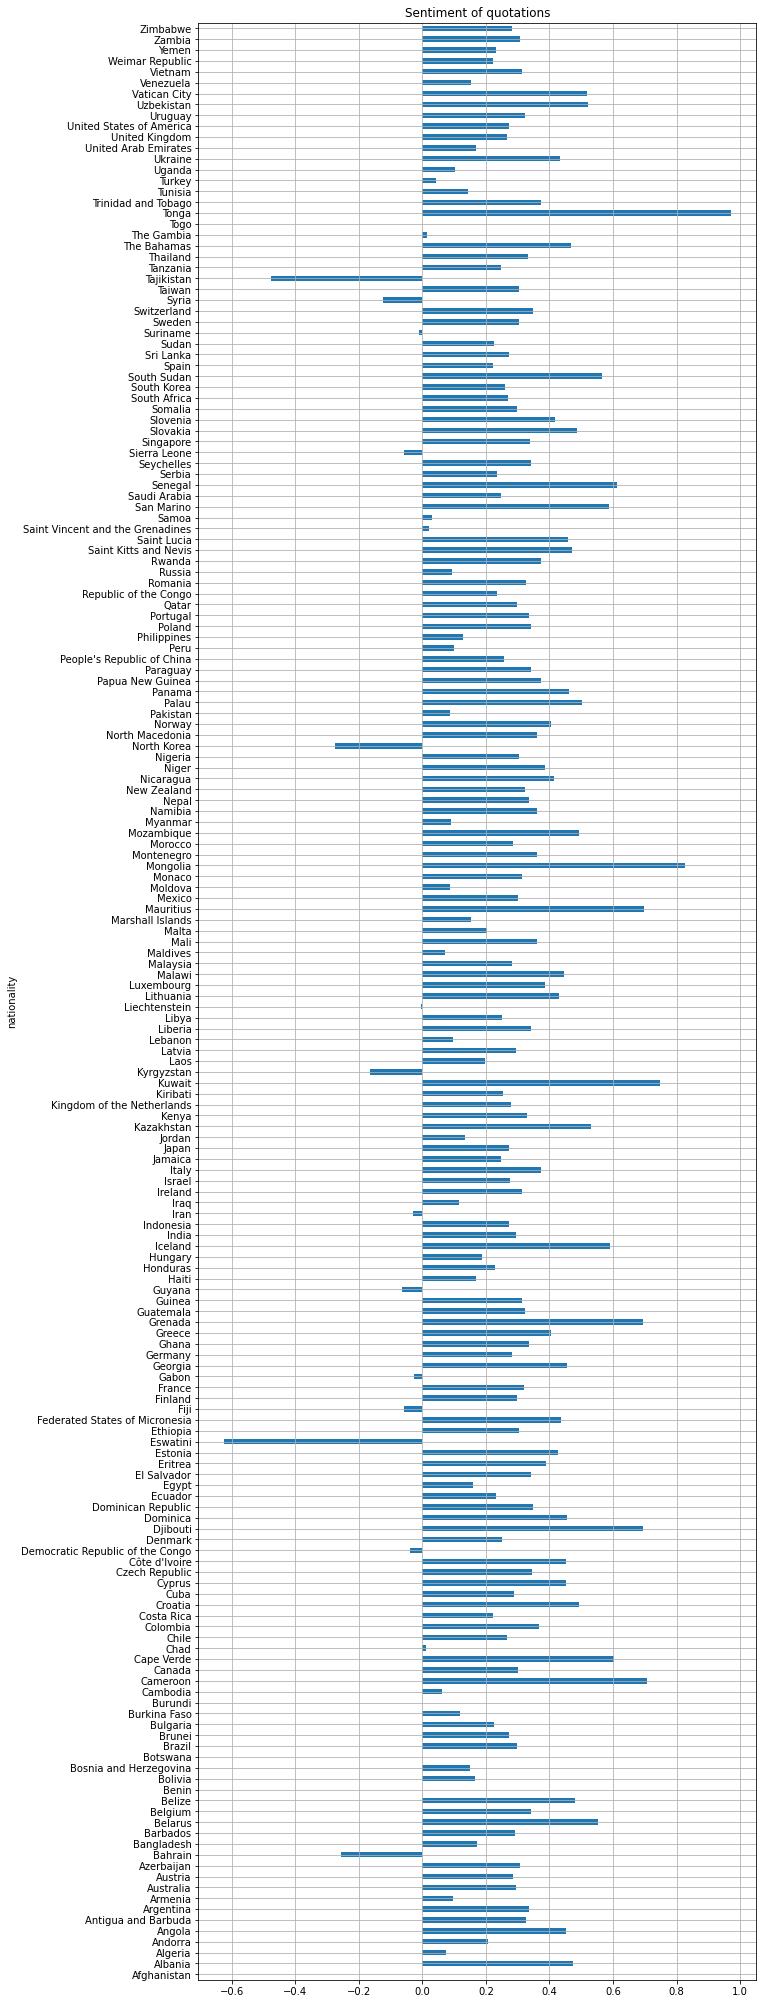

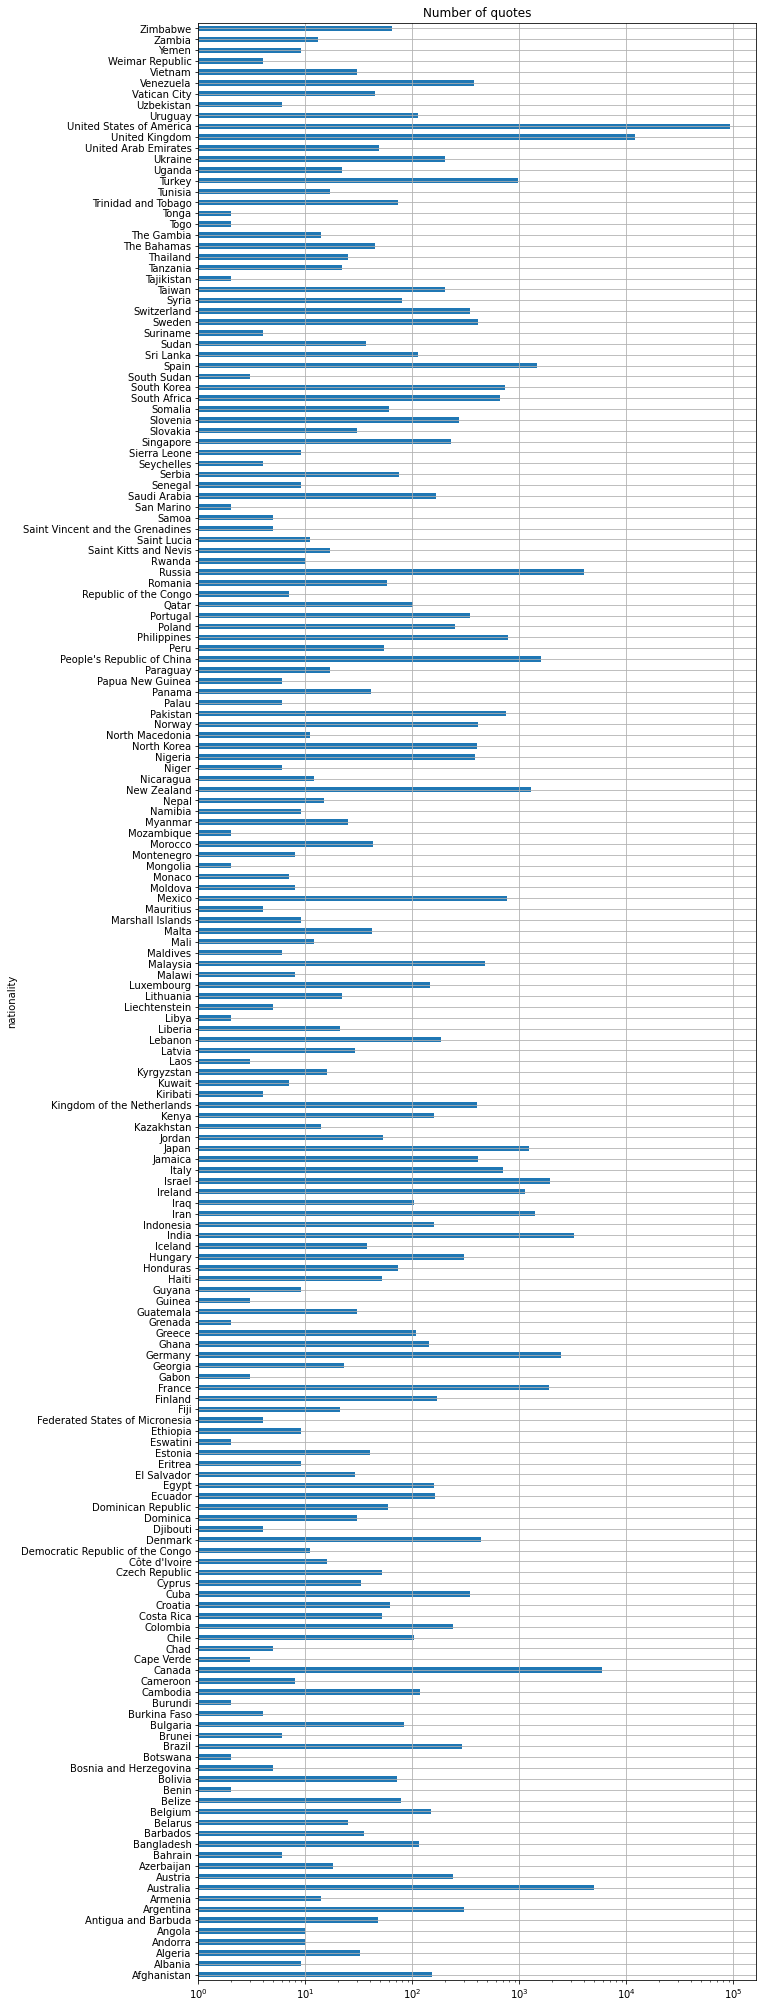

In [8]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 36))
plt.title("Sentiment of quotations")
#average sentiment for each country
US_love_mean = US_with_nation.groupby("nationality")["sentiment"].mean()
US_love_mean.plot.barh(grid=True)

plt.figure(figsize=(10,36))
plt.title("Number of quotes")
#count the number of quotes for each country
US_with_nation.groupby("nationality")["sentiment"].count().plot.barh(grid=True, log=True, align='center')


To make a brief analysis, in overall, most the countries seem at first sight more favorable to the USA.. Unsuprisingly the distribution of the number of quotes per country is highly non-uniform.

#### Map creation

In [22]:
import geopandas
#load world map dataframe
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
#connect US_data with map dataframe
table = world.merge(US_love_mean, how="left", left_on=['name'], right_on=['nationality'])


# Clean data: remove rows with no data
table = table.dropna(subset=['sentiment'])

In [24]:
import folium

#create Map object to do the plot
my_map = folium.Map()

# Map parameters with as color foreach country its sentiment average
folium.Choropleth(
    geo_data=table,
    name='choropleth',
    data=table,
    columns=['name', 'sentiment'],
    key_on='feature.properties.name',
    fill_color='RdYlGn',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Sentiment of Quotes',
    missing_kwds={'color': 'white'}
).add_to(my_map)

#Save Map figure
my_map.save('us_love.html')

## 6. Load PEW Research Center Dataset

In this section, the datasets provided by PEW research center are loaded and processed.
We extract the nationality, sex, age of the participants and also their answer to the question: "How much you like the
United States?"

In [16]:
!pip install pyreadstat

In [9]:
column_names = ['country', 'fav_us', 'sex', 'age']

#columns labels foreach year (have changed over time)
#"fav_US" denoting their negative or positive view (i.e. their "sentiments") towards the U.S.A.
columns = {2015: ['COUNTRY', 'Q12A', 'Q145', 'Q146'],
           2016: ['country', 'Q10A', 'q107', 'q108'],
           2017: ['Country', 'fav_US', 'sex', 'age'],
           2018: ['COUNTRY', 'fav_US', 'sex', 'age'],
           2019: ['country', 'FAV_US', 'SEX', 'AGE'],
           2020: ['country', 'fav_US', 'sex', 'age']}

pew = pd.DataFrame()

for year in range(2015, 2021):
    #create dataframe from PEW dataset
    pew_year = pd.read_spss("input/pew/{}.sav".format(year))
    pew_year_fav = pew_year[columns[year]]
    pew_year_fav.columns = column_names
    pew_year_fav['year'] = year
    #concat each year to one dataframe
    pew = pd.concat([pew, pew_year_fav], axis=0, ignore_index=True)

#Save the pew dataframe
pew.to_csv('input/pew.csv', index=False)


KeyboardInterrupt: 

In [10]:
import pandas as pd
import numpy as np

pew = pd.read_csv('input/pew.csv')

#List of "invalid" answers in pew dataset
Nan_keywords = ['Refused', 'Don’t know', 'Don’t know (DO NOT READ)', 'Refused (DO NOT READ)',
       '(VOL) Refused', "(VOL)\xa0Don't know"]

pew = pew.replace(to_replace=Nan_keywords, value=np.NaN)

#map "sentiment" to float values
fav_dict = {'Somewhat favorable': 0.5, 'Very favorable':1,
       'Somewhat unfavorable':-0.5, 'Very unfavorable':-1}

pew = pew.replace(fav_dict)


pew.sample(n=5)


,country,fav_us,sex,age,year
115245,Germany,-0.5,Female,61.0,2018
19987,Pakistan,-1.0,Female,29.0,2015
62689,Hungary,0.5,Female,51.0,2016
144332,Bulgaria,1.0,Female,48.0,2019
166433,Poland,0.5,Male,58.0,2019


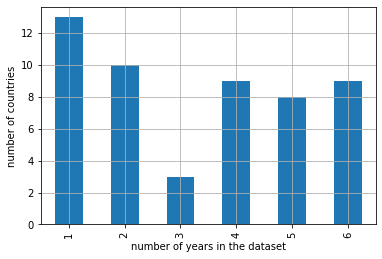

In [30]:
# foreach country, count the number of years it has appeared in the PEW yearly report
# then count the number of country who has appeared 1, 2, 3 times, etc...
pew.groupby('country')['year'].nunique().value_counts().sort_index(ascending=True).plot(kind='bar')
plt.xlabel('number of years in the dataset')
plt.ylabel('number of countries')
plt.grid()



Unique Countries: 52


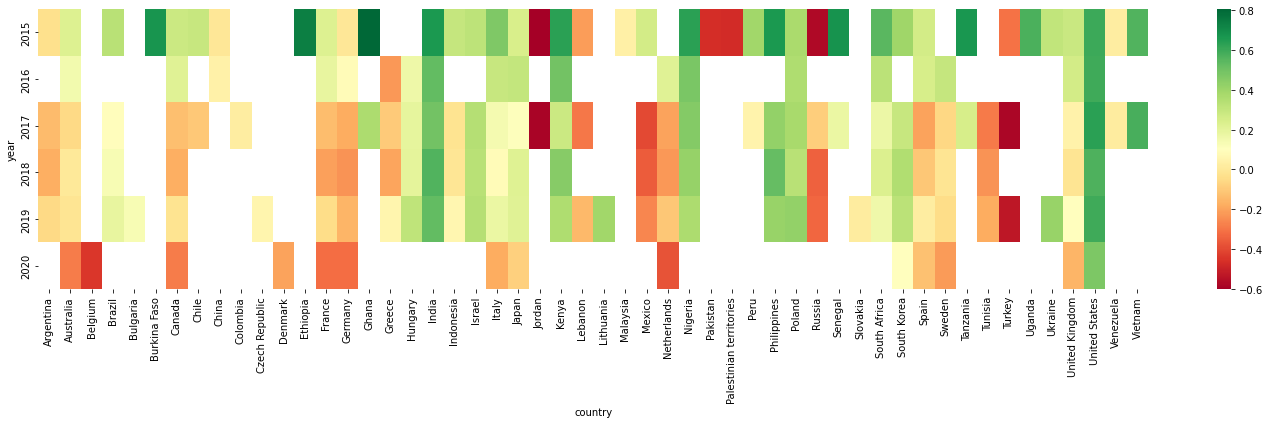

In [64]:
# heatmap for countries and years
import seaborn as sns
import matplotlib.pyplot as plt

pew_fav_us = pew.groupby(['country', 'year'], as_index=False)['fav_us'].mean()
pew_fav_pivot = pew_fav_us.pivot(index='year', columns='country', values='fav_us')
# pew_fav_pivot
plt.figure(figsize=(20,6))
sns.heatmap(pew_fav_pivot, cmap ='RdYlGn')
plt.tight_layout()
plt.savefig("output/pew_heatmap.jpg")
print("Unique Countries: {}".format(pew_fav_us.country.nunique()))

As we can see, there is few countries that have been analysed over all the years (only 9), and in total only around 50 countries appears in their reports.

### 7. Compare the datasets of PEW and QuoteSentiment

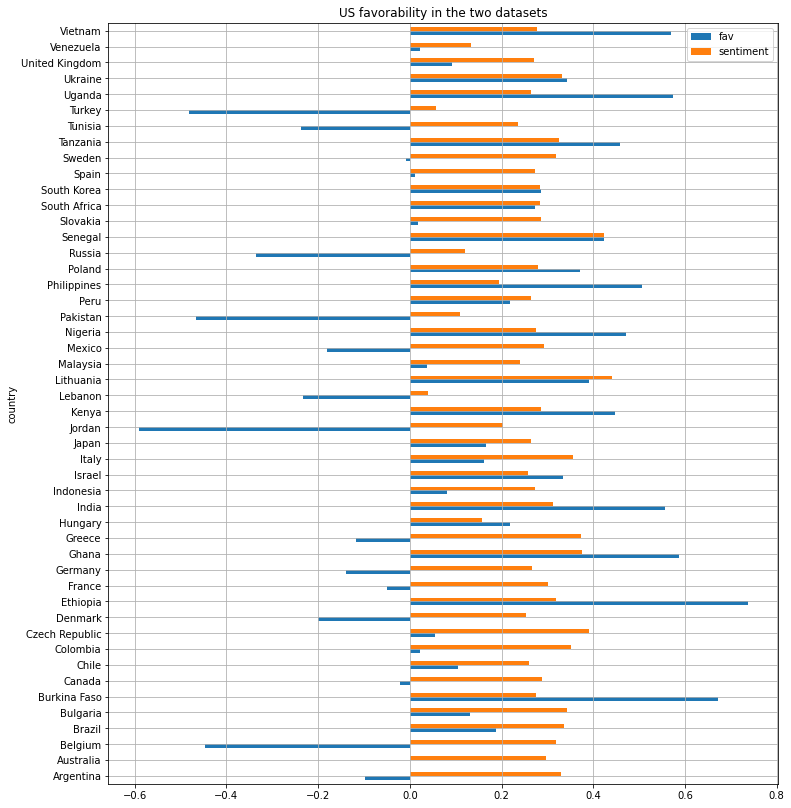

In [31]:
#Compute the mean sentiment for each country from the pew dataset report
pew_fav_us = pew.groupby('country')['fav_us'].mean().reset_index(name='fav')
quote_fav_us = US_love_mean.reset_index()
# merge the results of our sentiment analysis and the results of the pew dataset to create the plot
pew_quote_df = pd.merge(left=pew_fav_us, right=US_love_mean, left_on='country', right_on='nationality')

pew_quote_df.plot(x= 'country', figsize=(12,14), kind='barh')
plt.title("US favorability in the two datasets")
plt.grid()

It appears that there is a large difference between the quotations sentiment analysis we have made and the one made in the pew study. We should not forget that this first analysis was made over a small dataset containing just one year.

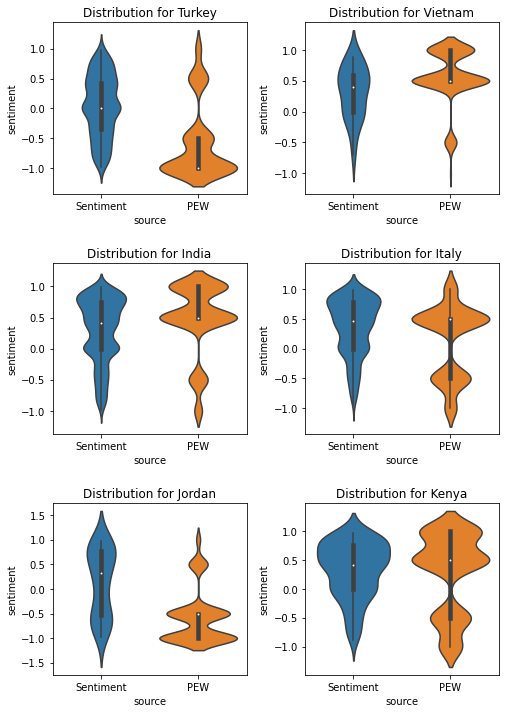

In [58]:
import seaborn as sns
US_with_nation["source"] = "Sentiment"
pew["source"] = "PEW"
pew = pew.rename(columns={'fav_us': 'sentiment'})
fig = plt.figure(figsize=(8,12))
for idx, country_name in enumerate(["Turkey", "Vietnam", "India", "Italy", "Jordan", "Kenya"]):
    country_sentiment = US_with_nation[US_with_nation.nationality==country_name][["sentiment", "source"]]
    country_pew = pew[(pew.year==2017) & (pew.country==country_name)][["sentiment", "source"]]
    plt.subplot(3,2,idx+1)
    plt.title("Distribution for {}".format(country_name))
    sns.violinplot(x="source", y="sentiment", data=pd.concat([country_sentiment, country_pew]))

plt.subplots_adjust(wspace=0.3, hspace=0.4)
